# Page Parser Pipeline Showcase

This notebook demonstrates the page-parser pipeline functionality, including document processing, layout detection, text extraction, and image annotation capabilities.

## Setup and Imports

In [1]:
import sys
import json
from pathlib import Path
import cv2
import numpy as np
from typing import List, Dict, Any
import matplotlib.pyplot as plt
from PIL import Image

# Add src to path for imports
sys.path.append('src')

from src.pipeline import pipeline
from src.pipeline.document import pdf_to_png, Detector
from src.pipeline.image import annotate_image
from src.config.settings import get_settings
from src.common.logging import setup_logging, get_logger

## Initialize Logging and Settings

In [2]:
# Setup logging
setup_logging(log_level="INFO")
logger = get_logger("pipeline_showcase")

# Load settings
settings = get_settings(Path("settings.toml"))
print(f"Vision provider: {settings.vision.provider.name}")
print(f"Model: {settings.vision.provider.model}")
print(f"Chart labels: {settings.filtration.chart_labels}")
print(f"OCR language: {settings.processing.ocr_lang}")
print(f"Zoom factor: {settings.processing.zoom_factor}")

Vision provider: ollama
Model: gemma3
Chart labels: ['picture', 'figure', 'chart', 'diagram']
OCR language: eng
Zoom factor: 2


## PDF to PNG Conversion

First, let's convert a PDF document to PNG images for processing.

In [3]:
# Convert PDF to PNG
pdf_path = "data/2507.21509v1.pdf"
temp_output_dir = "temp_images"
Path(temp_output_dir).mkdir(exist_ok=True)

logger.info(f"Converting PDF: {pdf_path}")
image_paths = pdf_to_png(
    pdf_path=pdf_path,
    output_dir=temp_output_dir,
    zoom_x=settings.processing.zoom_factor,
    zoom_y=settings.processing.zoom_factor,
)

print(f"Generated {len(image_paths)} page images:")
for i, path in enumerate(image_paths[:3]):  # Show first 3
    print(f"  Page {i+1}: {path}")
if len(image_paths) > 3:
    print(f"  ... and {len(image_paths) - 3} more")

2025-08-05 17:31:19.755 | INFO     | __main__:<module>:6 | Converting PDF: data/2507.21509v1.pdf
2025-08-05 17:31:19.757 | INFO     | src.pipeline.document.convert:pdf_to_png:66 | Converting PDF to PNG: data/2507.21509v1.pdf
2025-08-05 17:31:19.757 | INFO     | src.pipeline.document.convert:pdf_to_png:67 | Output directory: temp_images
2025-08-05 17:31:19.758 | INFO     | src.pipeline.document.convert:pdf_to_png:68 | Zoom factors: x=2, y=2
2025-08-05 17:31:19.759 | INFO     | src.pipeline.document.convert:pdf_to_png:69 | Colorspace: rgb
2025-08-05 17:31:19.766 | INFO     | src.pipeline.document.convert:pdf_to_png:74 | PDF has 60 pages
2025-08-05 17:31:38.544 | INFO     | src.pipeline.document.convert:pdf_to_png:96 | Successfully converted 60 pages to PNG


Generated 60 page images:
  Page 1: temp_images\page_1.png
  Page 2: temp_images\page_2.png
  Page 3: temp_images\page_3.png
  ... and 57 more


## Display Sample Page

Let's display the first page to see what we're working with.

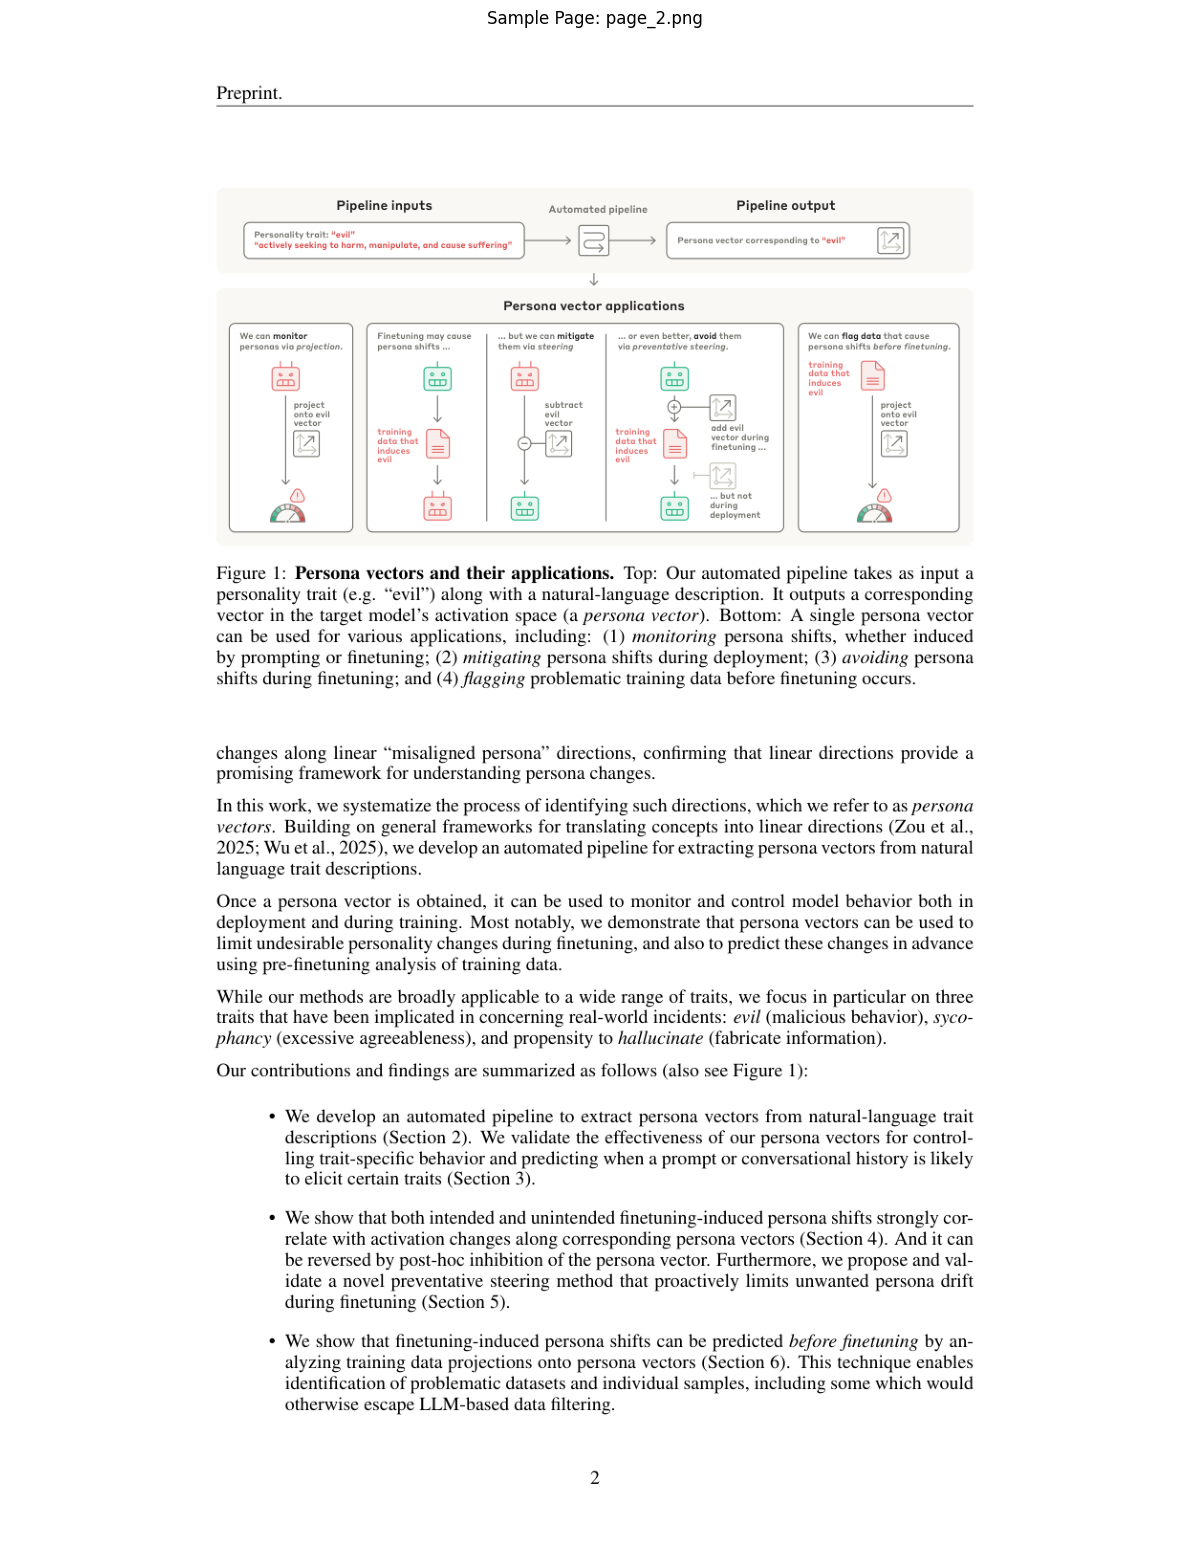

Image dimensions: (1224, 1584)


In [4]:
# Display second page
second_page_path = image_paths[1]
img = Image.open(second_page_path)

plt.figure(figsize=(12, 16))
plt.imshow(img)
plt.axis('off')
plt.title(f"Sample Page: {Path(second_page_path).name}")
plt.tight_layout()
plt.show()

print(f"Image dimensions: {img.size}")

## Layout Detection

Now let's use the YOLO detector to identify different elements in the document.

In [5]:
# Initialize detector
model_path = "models/yolov12l-doclaynet.pt"
detector = Detector(model_path=model_path)

print(f"Detector initialized with model: {model_path}")
print(f"Model class names: {detector.model.names}")

2025-08-05 17:31:39.094 | INFO     | src.pipeline.document.detector:__init__:54 | Initializing YOLO detector with model: models/yolov12l-doclaynet.pt
2025-08-05 17:31:39.804 | INFO     | src.pipeline.document.detector:__init__:59 | YOLO detector initialized successfully


Detector initialized with model: models/yolov12l-doclaynet.pt
Model class names: {0: 'Caption', 1: 'Footnote', 10: 'Title', 2: 'Formula', 3: 'List-item', 4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 7: 'Section-header', 8: 'Table', 9: 'Text'}


In [6]:
# Detect layout elements in the first page
detections = detector.parse_layout(Path(second_page_path))

print(f"Found {len(detections)} elements:")
for i, detection in enumerate(detections):
    x1, y1, x2, y2 = detection.bbox
    width = x2 - x1
    height = y2 - y1
    print(f"  {i+1}. {detection.label_name} (confidence: {detection.confidence:.3f}) - Size: {width}x{height}")


0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 993.3ms
Speed: 7.5ms preprocess, 993.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:31:43.519 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 12 objects found


Found 12 elements:
  1. List-item (confidence: 0.972) - Size: 742.404752612114x89.52397441864014
  2. List-item (confidence: 0.969) - Size: 742.0345916748047x111.87548732757568
  3. List-item (confidence: 0.965) - Size: 741.5197952985764x90.62021255493164
  4. Picture (confidence: 0.963) - Size: 793.5816042423248x369.06119406223297
  5. Text (confidence: 0.958) - Size: 797.5002032518387x87.57008171081543
  6. Text (confidence: 0.956) - Size: 797.5491020679474x87.65241050720215
  7. Text (confidence: 0.948) - Size: 796.7343649864197x64.40576076507568
  8. Text (confidence: 0.938) - Size: 797.7352677583694x43.433207988739014
  9. Text (confidence: 0.908) - Size: 798.9269324541092x132.10188817977905
  10. Text (confidence: 0.773) - Size: 625.0667631626129x22.350285530090332
  11. Page-header (confidence: 0.713) - Size: 70.81635618209839x21.778214871883392
  12. Page-footer (confidence: 0.638) - Size: 17.378358364105225x21.250648498535156


## Image Annotation

Let's annotate the image with the detected bounding boxes and labels.

2025-08-05 17:31:43.527 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:31:43.548 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image


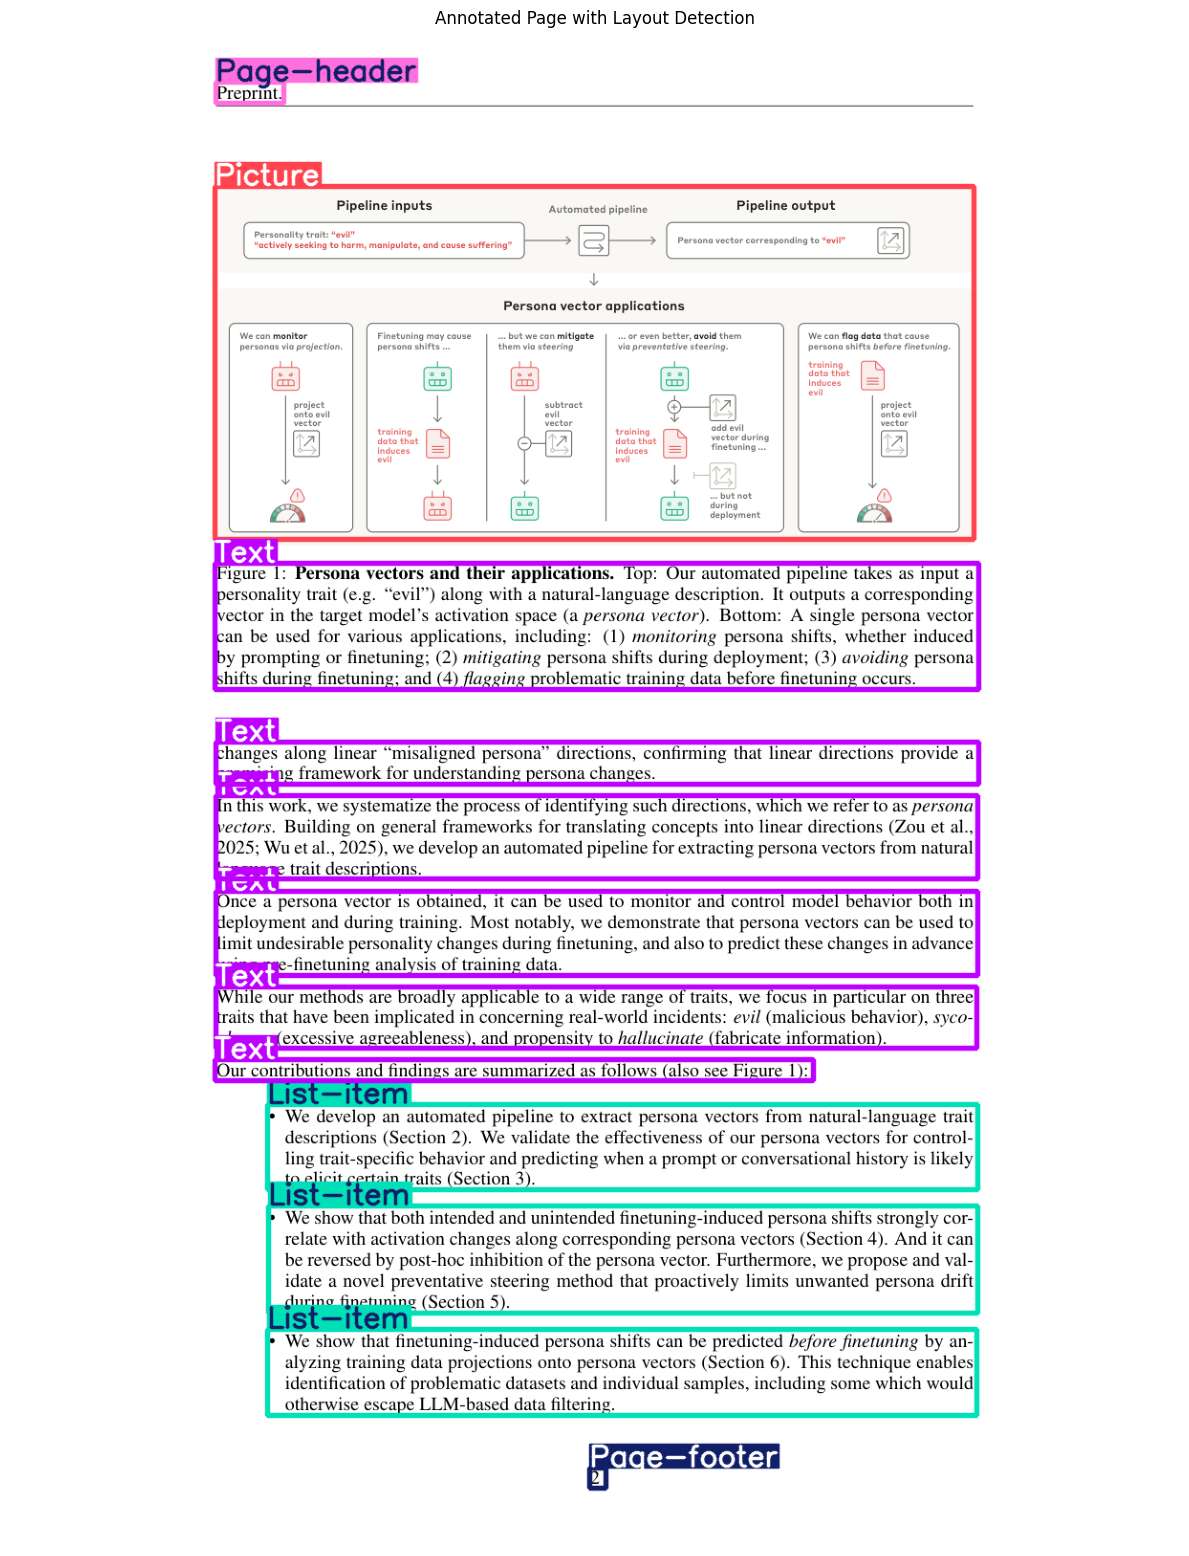

In [7]:
# Annotate the image with detections
annotated_img = annotate_image(
    image_path=str(second_page_path),
    detections=detections,
    line_width=3,
    font_size=12,
)

# Display annotated image
plt.figure(figsize=(12, 16))
# Convert BGR to RGB for matplotlib
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_img_rgb)
plt.axis('off')
plt.title("Annotated Page with Layout Detection")
plt.tight_layout()
plt.show()

## Filter Chart Elements

Let's filter the detections to focus on chart/figure elements.

In [8]:
from src.pipeline.utils import filter_detections

# Filter for chart elements
chart_labels = settings.filtration.chart_labels
chart_detections = filter_detections(detections, chart_labels)

print(f"Chart labels to filter: {chart_labels}")
print(f"Found {len(chart_detections)} chart/figure elements:")
for i, detection in enumerate(chart_detections):
    x1, y1, x2, y2 = detection.bbox
    width = x2 - x1
    height = y2 - y1
    print(f"  {i+1}. {detection.label_name} (confidence: {detection.confidence:.3f}) - Size: {width}x{height}")

Chart labels to filter: ['picture', 'figure', 'chart', 'diagram']
Found 1 chart/figure elements:
  1. Picture (confidence: 0.963) - Size: 793.5816042423248x369.06119406223297


2025-08-05 17:31:43.921 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:31:43.935 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image


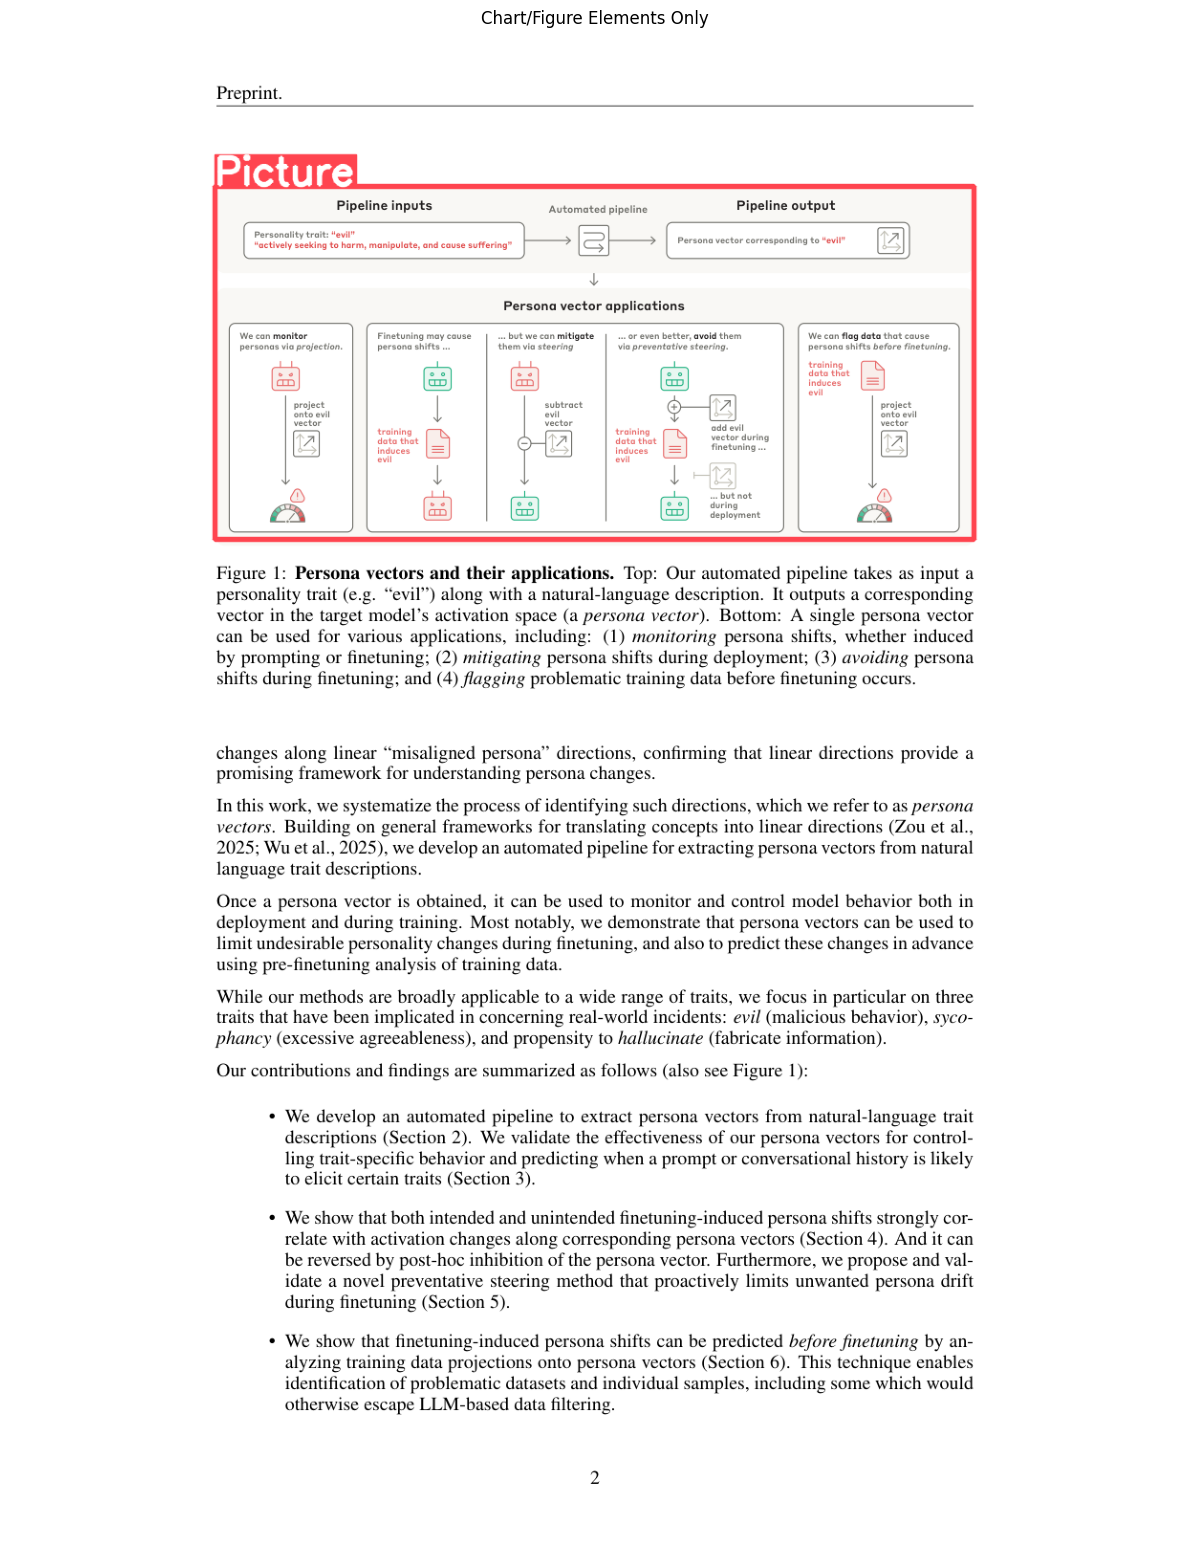

In [9]:
# Annotate image with only chart elements
if chart_detections:
    chart_annotated_img = annotate_image(
        image_path=str(second_page_path),
        detections=chart_detections,
        line_width=4,
        font_size=14,
    )
    
    # Display chart-only annotated image
    plt.figure(figsize=(12, 16))
    chart_annotated_img_rgb = cv2.cvtColor(chart_annotated_img, cv2.COLOR_BGR2RGB)
    plt.imshow(chart_annotated_img_rgb)
    plt.axis('off')
    plt.title("Chart/Figure Elements Only")
    plt.tight_layout()
    plt.show()
else:
    print("No chart elements found in this page.")

## Full Pipeline Execution

Now let's run the complete pipeline on a document to see the full workflow in action.

In [10]:
# Run full pipeline
output_dir = "showcase_output"
Path(output_dir).mkdir(exist_ok=True)

logger.info("Running full pipeline...")
try:
    results = pipeline(
        document_path=pdf_path,
        model_path=model_path,
        output_dir=output_dir,
        settings_file=Path("settings.toml"),
        page_limit=5,
    )
    
    print(f"\nPipeline completed successfully!")
    print(f"Processed {len(results)} pages")
    
    # Show summary statistics
    total_elements = sum(len(page['elements']) for page in results)
    chart_elements = sum(len([e for e in page['elements'] if e['type'] == 'chart']) for page in results)
    text_elements = sum(len([e for e in page['elements'] if e['type'] == 'text']) for page in results)
    
    print(f"Total elements extracted: {total_elements}")
    print(f"  - Chart elements: {chart_elements}")
    print(f"  - Text elements: {text_elements}")
    
except Exception as e:
    print(f"Pipeline failed: {e}")
    logger.error(f"Pipeline error: {e}", exc_info=True)

2025-08-05 17:31:44.232 | INFO     | __main__:<module>:5 | Running full pipeline...
2025-08-05 17:31:44.233 | INFO     | src.pipeline.pipeline:pipeline:42 | Starting document processing pipeline
2025-08-05 17:31:44.235 | INFO     | src.pipeline.pipeline:pipeline:64 | Converting PDF to PNG images
2025-08-05 17:31:44.235 | INFO     | src.pipeline.document.convert:pdf_to_png:66 | Converting PDF to PNG: data/2507.21509v1.pdf
2025-08-05 17:31:44.236 | INFO     | src.pipeline.document.convert:pdf_to_png:67 | Output directory: C:\Users\dev\AppData\Local\Temp\tmpasqct6kv
2025-08-05 17:31:44.236 | INFO     | src.pipeline.document.convert:pdf_to_png:68 | Zoom factors: x=2, y=2
2025-08-05 17:31:44.237 | INFO     | src.pipeline.document.convert:pdf_to_png:69 | Colorspace: rgb
2025-08-05 17:31:44.241 | INFO     | src.pipeline.document.convert:pdf_to_png:74 | PDF has 60 pages
2025-08-05 17:31:52.518 | INFO     | src.pipeline.document.convert:pdf_to_png:96 | Successfully converted 60 pages to PNG
202


0: 1024x800 3 Footnotes, 1 Page-footer, 2 Page-headers, 2 Section-headers, 8 Texts, 2 Titles, 970.1ms
Speed: 7.9ms preprocess, 970.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:31:54.484 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 18 objects found
2025-08-05 17:31:54.485 | INFO     | src.pipeline.pipeline:process_chart_elements:184 | Processing chart elements for page 1
2025-08-05 17:31:54.486 | INFO     | src.pipeline.pipeline:process_chart_elements:187 | No chart detections found, skipping chart processing
2025-08-05 17:31:54.486 | INFO     | src.pipeline.pipeline:process_text_elements:247 | Processing text elements for page 1
2025-08-05 17:31:54.564 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:32 | Filled 0 regions in 'page_1' and saved to 'text_processed_1'.
2025-08-05 17:31:56.223 | INFO     | src.pipeline.pipeline:process_text_elements:286 | Successfully extracted text from processed image
2025-08-05 17:31:56.223 | INFO     | src.pipeline.pipeline:process_text_elements:290 | Successfully processed 1 text elements
2025-08-05 17:31:56.225 | INFO     | src.pipeline.pipeli


0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 980.8ms
Speed: 11.8ms preprocess, 980.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:31:57.242 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 12 objects found
2025-08-05 17:31:57.243 | INFO     | src.pipeline.pipeline:process_chart_elements:184 | Processing chart elements for page 2
2025-08-05 17:31:57.267 | INFO     | src.pipeline.image.preprocessing:extract_regions:66 | Extracted 1 regions from 'page_2' to 'cropped_2/page_2'.
2025-08-05 17:33:07.942 | INFO     | src.pipeline.pipeline:process_chart_elements:223 | Successfully processed 1 chart elements
2025-08-05 17:33:07.943 | INFO     | src.pipeline.pipeline:process_text_elements:247 | Processing text elements for page 2
2025-08-05 17:33:07.989 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:32 | Filled 1 regions in 'page_2' and saved to 'text_processed_2'.
2025-08-05 17:33:09.194 | INFO     | src.pipeline.pipeline:process_text_elements:286 | Successfully extracted text from processed image
2025-08-05 17:33:09.194 | INFO     | src.pipeli


0: 1024x800 1 Caption, 1 Footnote, 1 Page-footer, 1 Page-header, 1 Picture, 3 Section-headers, 5 Texts, 962.9ms
Speed: 9.3ms preprocess, 962.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:33:10.193 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 13 objects found
2025-08-05 17:33:10.193 | INFO     | src.pipeline.pipeline:process_chart_elements:184 | Processing chart elements for page 3
2025-08-05 17:33:10.209 | INFO     | src.pipeline.image.preprocessing:extract_regions:66 | Extracted 1 regions from 'page_3' to 'cropped_3/page_3'.
2025-08-05 17:34:20.361 | INFO     | src.pipeline.pipeline:process_chart_elements:223 | Successfully processed 1 chart elements
2025-08-05 17:34:20.362 | INFO     | src.pipeline.pipeline:process_text_elements:247 | Processing text elements for page 3
2025-08-05 17:34:20.417 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:32 | Filled 1 regions in 'page_3' and saved to 'text_processed_3'.
2025-08-05 17:34:21.673 | INFO     | src.pipeline.pipeline:process_text_elements:286 | Successfully extracted text from processed image
2025-08-05 17:34:21.674 | INFO     | src.pipeli


0: 1024x800 1 Caption, 2 Footnotes, 1 Formula, 1 Page-footer, 1 Page-header, 1 Picture, 3 Section-headers, 4 Texts, 992.8ms
Speed: 6.7ms preprocess, 992.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:34:22.699 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 14 objects found
2025-08-05 17:34:22.699 | INFO     | src.pipeline.pipeline:process_chart_elements:184 | Processing chart elements for page 4
2025-08-05 17:34:22.725 | INFO     | src.pipeline.image.preprocessing:extract_regions:66 | Extracted 1 regions from 'page_4' to 'cropped_4/page_4'.
2025-08-05 17:35:46.432 | INFO     | src.pipeline.pipeline:process_chart_elements:223 | Successfully processed 1 chart elements
2025-08-05 17:35:46.433 | INFO     | src.pipeline.pipeline:process_text_elements:247 | Processing text elements for page 4
2025-08-05 17:35:46.476 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:32 | Filled 1 regions in 'page_4' and saved to 'text_processed_4'.
2025-08-05 17:35:47.601 | INFO     | src.pipeline.pipeline:process_text_elements:286 | Successfully extracted text from processed image
2025-08-05 17:35:47.602 | INFO     | src.pipeli


0: 1024x800 1 Footnote, 1 Page-footer, 1 Page-header, 1 Picture, 1 Section-header, 6 Texts, 988.7ms
Speed: 6.7ms preprocess, 988.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 17:35:48.623 | INFO     | src.pipeline.document.detector:parse_layout:113 | Layout detection completed: 11 objects found
2025-08-05 17:35:48.623 | INFO     | src.pipeline.pipeline:process_chart_elements:184 | Processing chart elements for page 5
2025-08-05 17:35:48.641 | INFO     | src.pipeline.image.preprocessing:extract_regions:66 | Extracted 1 regions from 'page_5' to 'cropped_5/page_5'.
2025-08-05 17:37:13.514 | INFO     | src.pipeline.pipeline:process_chart_elements:223 | Successfully processed 1 chart elements
2025-08-05 17:37:13.515 | INFO     | src.pipeline.pipeline:process_text_elements:247 | Processing text elements for page 5
2025-08-05 17:37:13.564 | INFO     | src.pipeline.image.preprocessing:fill_regions_with_color:32 | Filled 1 regions in 'page_5' and saved to 'text_processed_5'.
2025-08-05 17:37:14.842 | INFO     | src.pipeline.pipeline:process_text_elements:286 | Successfully extracted text from processed image
2025-08-05 17:37:14.843 | INFO     | src.pipeli


Pipeline completed successfully!
Processed 5 pages
Total elements extracted: 9
  - Chart elements: 4
  - Text elements: 5


## Examine Pipeline Results

Let's look at the detailed results from the pipeline execution.

In [11]:
# Display results for first page
if 'results' in locals() and results:
    first_page_result = results[0]
    
    print(f"Page {first_page_result['page_number']} Results:")
    print(f"Number of elements: {len(first_page_result['elements'])}")
    print("\nElement breakdown:")
    
    for i, element in enumerate(first_page_result['elements']):
        print(f"\nElement {i+1}:")
        print(f"  Type: {element['type']}")
        
        if element['type'] == 'chart':
            print(f"  Label: {element['label']}")
            print(f"  Bbox: {element['bbox']}")
            print(f"  Summary: {element['summary'][:200]}..." if len(element['summary']) > 200 else f"  Summary: {element['summary']}")
        elif element['type'] == 'text':
            print(f"  Bbox: {element['bbox']}")
            print(f"  Text preview: {element['text'][:200]}..." if len(element['text']) > 200 else f"  Text: {element['text']}")
else:
    print("No pipeline results available.")

Page 1 Results:
Number of elements: 1

Element breakdown:

Element 1:
  Type: text
  Bbox: (0, 0, 1224, 1584)
  Text preview: Preprint.
PERSONA VECTORS: MONITORING AND CONTROLLING
CHARACTER TRAITS IN LANGUAGE MODELS
Runjin Chen*#!2 Andy Arditi'! Henry Sleight? Owain Evans'5 Jack Lindsey!*®
lAnthropic Fellows Program ?UT Aust...


## Advanced Annotation Examples

Let's demonstrate more advanced annotation features with different styling options.

2025-08-05 17:37:14.885 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:37:14.900 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image
2025-08-05 17:37:14.901 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:37:14.917 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image


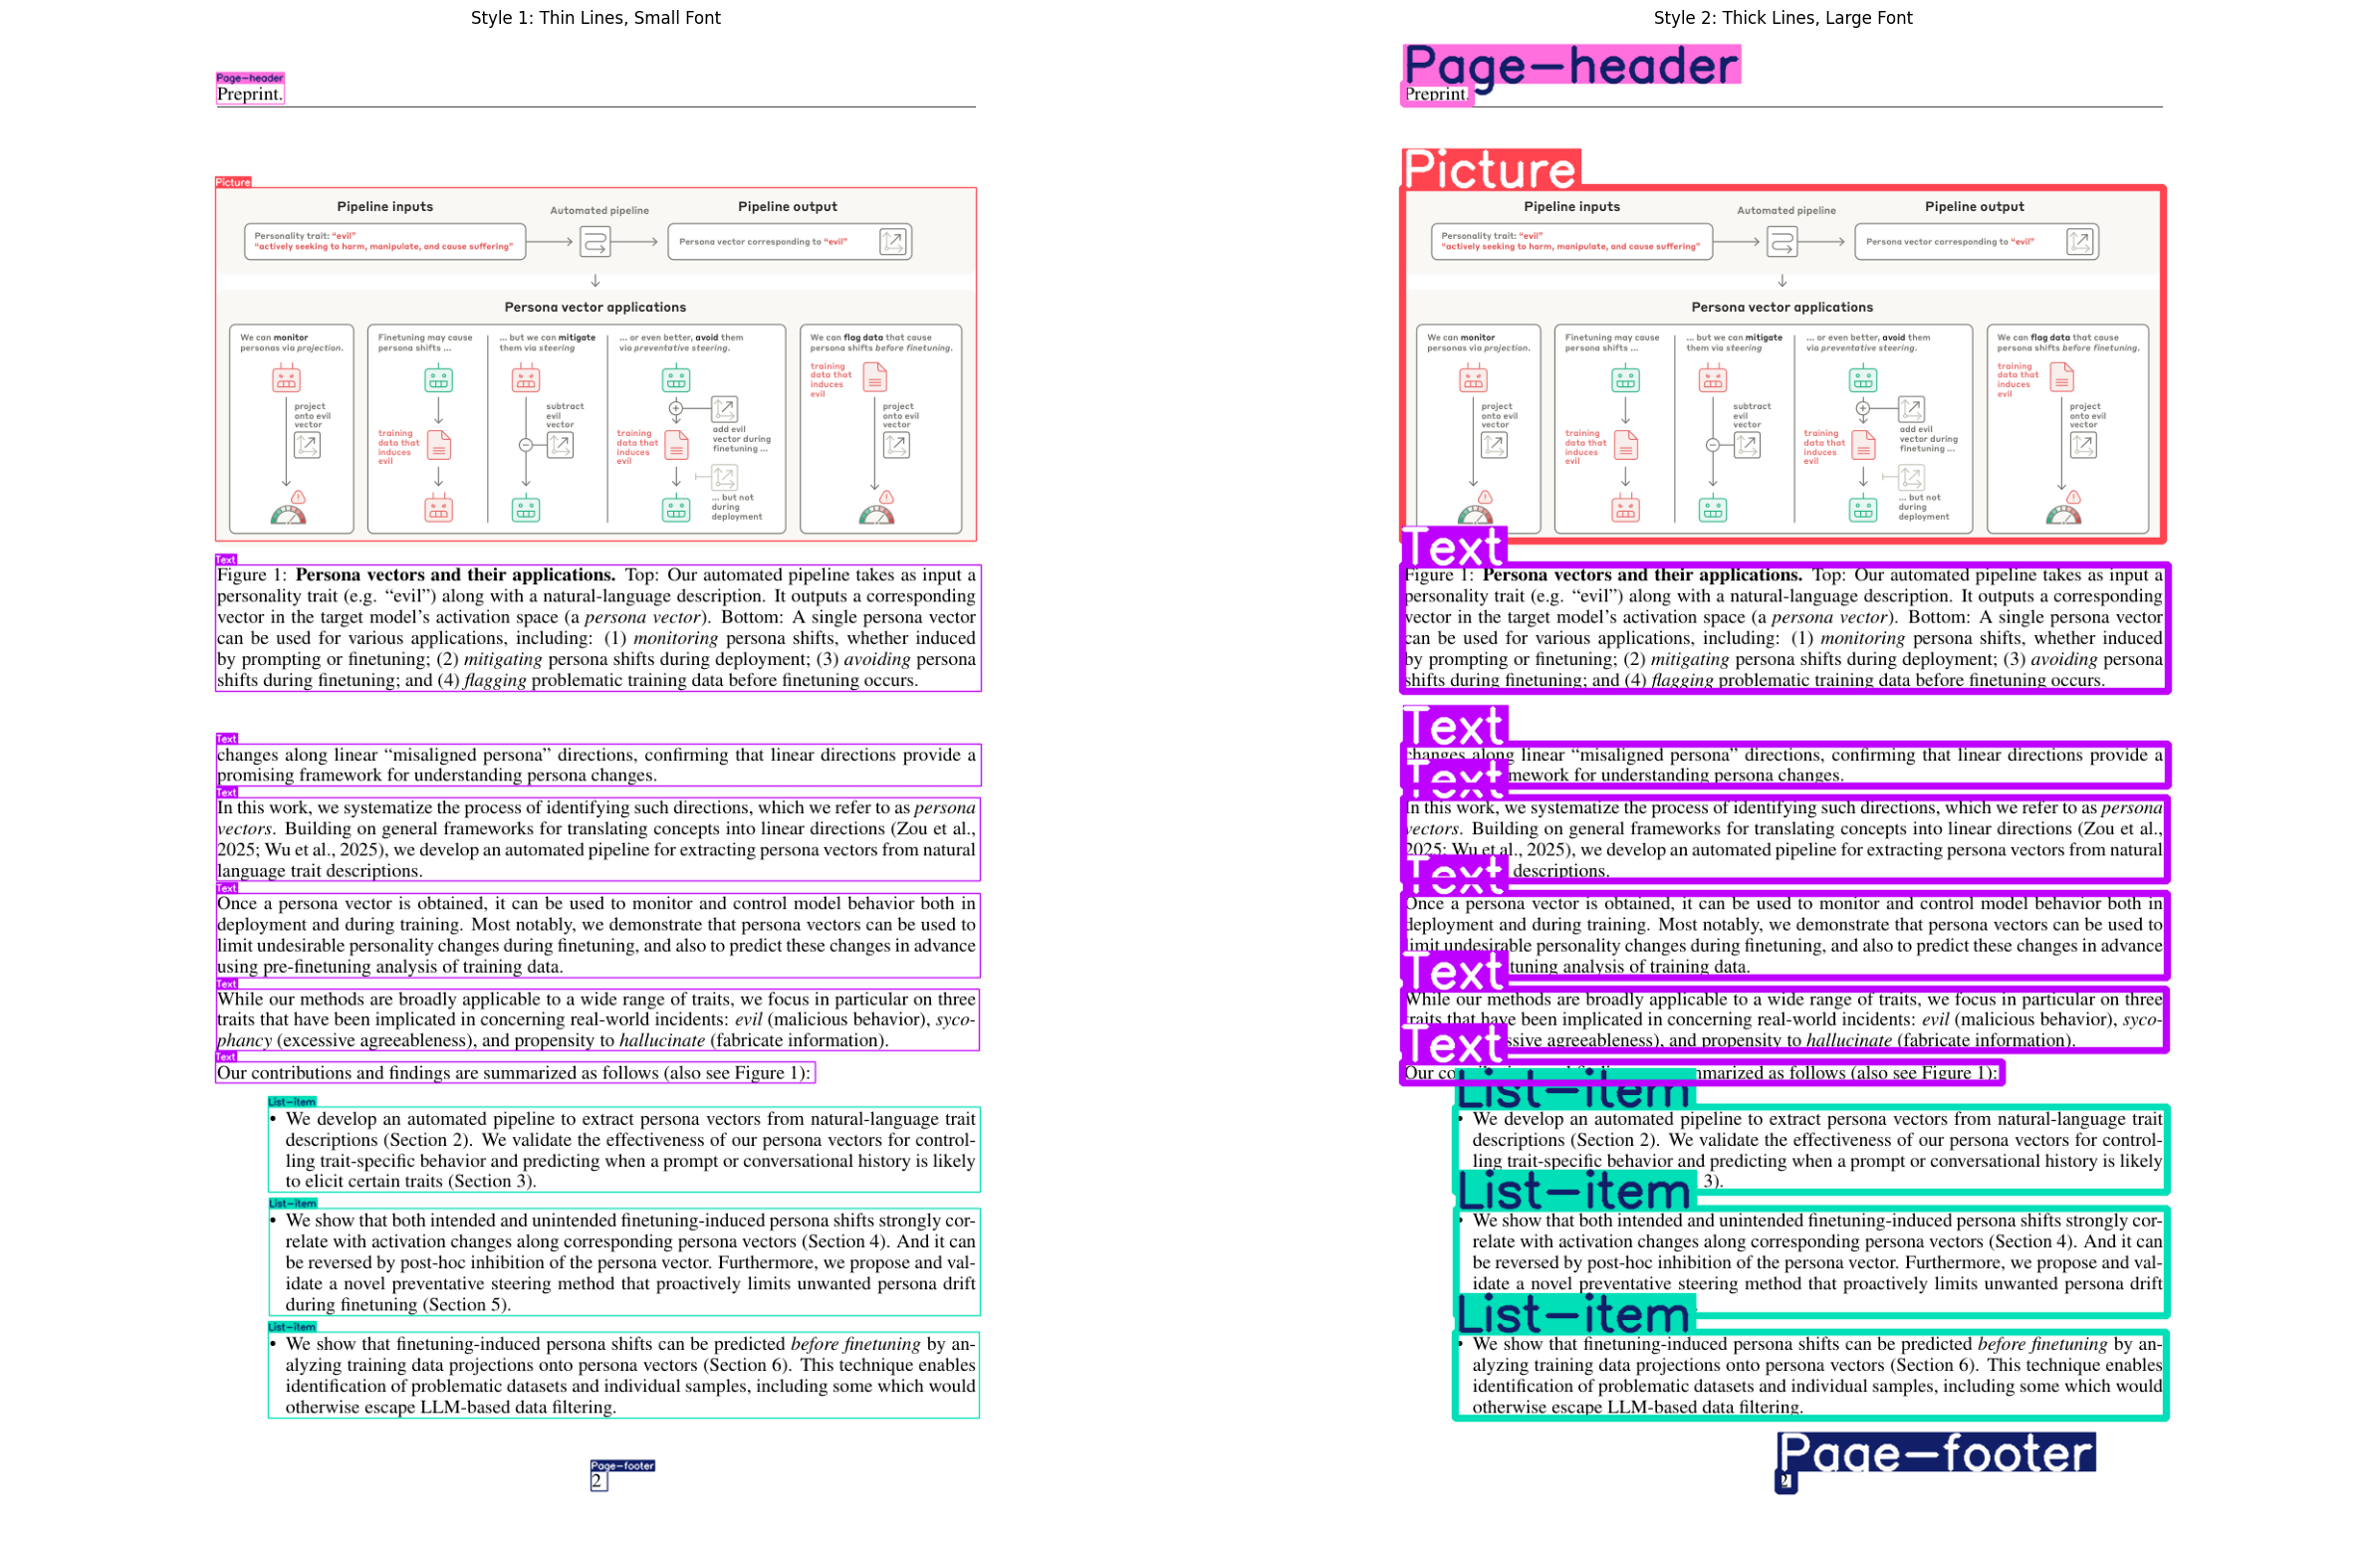

In [12]:
# Create multiple annotation styles
from src.pipeline.image.annotate import Fonts

if detections:
    # Style 1: Thin lines, small font
    style1_img = annotate_image(
        image_path=str(second_page_path),
        detections=detections,
        line_width=1,
        font=Fonts.Arial,
        font_size=8,
    )
    
    # Style 2: Thick lines, large font
    style2_img = annotate_image(
        image_path=str(second_page_path),
        detections=detections,
        line_width=5,
        font=Fonts.Consolas,
        font_size=16,
    )
    
    # Display both styles side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
    
    ax1.imshow(cv2.cvtColor(style1_img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Style 1: Thin Lines, Small Font")
    ax1.axis('off')
    
    ax2.imshow(cv2.cvtColor(style2_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("Style 2: Thick Lines, Large Font")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No detections available for styling demonstration.")

## Save Annotated Images

Let's save some annotated images to the output directory.

In [13]:
# Save annotated images with different styles
save_dir = Path(output_dir) / "annotated_images"
save_dir.mkdir(exist_ok=True)

if detections:
    # Save full annotation
    full_annotated = annotate_image(
        image_path=str(second_page_path),
        detections=detections,
        line_width=3,
        font_size=12,
        autosave=True,
        save_path=str(save_dir / "full_annotated.png")
    )
    
    # Save chart-only annotation if charts exist
    if chart_detections:
        chart_only_annotated = annotate_image(
            image_path=str(second_page_path),
            detections=chart_detections,
            line_width=4,
            font_size=14,
            autosave=True,
            save_path=str(save_dir / "charts_only.png")
        )
    
    print(f"Annotated images saved to: {save_dir}")
    print(f"Files created:")
    for file in save_dir.glob("*.png"):
        print(f"  - {file.name}")
else:
    print("No detections to save.")

2025-08-05 17:37:15.507 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:37:15.526 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image
2025-08-05 17:37:15.555 | INFO     | src.pipeline.image.annotate:annotate_image:82 | Successfully saved annotated image to showcase_output\annotated_images\full_annotated.png
2025-08-05 17:37:15.556 | INFO     | src.pipeline.image.annotate:annotate_image:55 | Annotating image: temp_images\page_2.png
2025-08-05 17:37:15.570 | INFO     | src.pipeline.image.annotate:annotate_image:76 | Successfully annotated image
2025-08-05 17:37:15.592 | INFO     | src.pipeline.image.annotate:annotate_image:82 | Successfully saved annotated image to showcase_output\annotated_images\charts_only.png


Annotated images saved to: showcase_output\annotated_images
Files created:
  - charts_only.png
  - full_annotated.png


## Pipeline Performance Summary

Let's create a summary of the pipeline's performance and capabilities.

In [14]:
# Create performance summary
print("=" * 50)
print("PAGE PARSER PIPELINE SHOWCASE SUMMARY")
print("=" * 50)

print(f"\nInput Document: {Path(pdf_path).name}")
print(f"Model Used: {Path(model_path).name}")
print(f"Pages Converted: {len(image_paths)}")
print(f"Elements Detected (Page 1): {len(detections)}")

if 'results' in locals() and results:
    total_pages = len(results)
    total_elements = sum(len(page['elements']) for page in results)
    total_charts = sum(len([e for e in page['elements'] if e['type'] == 'chart']) for page in results)
    total_text = sum(len([e for e in page['elements'] if e['type'] == 'text']) for page in results)
    
    print("\nFull Pipeline Results:")
    print(f"  Total Pages Processed: {total_pages}")
    print(f"  Total Elements Extracted: {total_elements}")
    print(f"  Chart Elements: {total_charts}")
    print(f"  Text Elements: {total_text}")

print("\nCapabilities Demonstrated:")
print("  ✓ PDF to PNG conversion")
print("  ✓ Layout detection with YOLO")
print("  ✓ Element filtering and classification")
print("  ✓ Image annotation with bounding boxes")
print("  ✓ Multiple annotation styles")
print("  ✓ Chart summarization (if configured)")
print("  ✓ Text extraction with OCR")
print("  ✓ JSON output generation")

print("\nOutput Files Generated:")
output_path = Path(output_dir)
if output_path.exists():
    for file in output_path.rglob("*.*"):
        if file.is_file():
            print(f"  - {file.relative_to(output_path)}")

print("\n" + "=" * 50)
print("Showcase completed successfully!")
print("=" * 50)

PAGE PARSER PIPELINE SHOWCASE SUMMARY

Input Document: 2507.21509v1.pdf
Model Used: yolov12l-doclaynet.pt
Pages Converted: 60
Elements Detected (Page 1): 12

Full Pipeline Results:
  Total Pages Processed: 5
  Total Elements Extracted: 9
  Chart Elements: 4
  Text Elements: 5

Capabilities Demonstrated:
  ✓ PDF to PNG conversion
  ✓ Layout detection with YOLO
  ✓ Element filtering and classification
  ✓ Image annotation with bounding boxes
  ✓ Multiple annotation styles
  ✓ Chart summarization (if configured)
  ✓ Text extraction with OCR
  ✓ JSON output generation

Output Files Generated:
  - page_1.json
  - page_2.json
  - page_3.json
  - page_4.json
  - page_5.json
  - annotated_images\charts_only.png
  - annotated_images\full_annotated.png

Showcase completed successfully!


## Cleanup

Clean up temporary files created during the showcase.

In [15]:
import shutil

# Clean up temporary image directory
temp_dir = Path(temp_output_dir)
if temp_dir.exists():
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")

print("\nShowcase completed! Check the output directory for generated files.")
print(f"Output directory: {Path(output_dir).absolute()}")

Cleaned up temporary directory: temp_images

Showcase completed! Check the output directory for generated files.
Output directory: d:\code\projects\page-parser\showcase_output
